# Network Analysis Project
## Crime Network Analysis
Professor: Michele Coscia

This notebook contains all of the code developed for the Network Analysis Course at ITU. We will be using...**finish**

**Add Description**

Group 10:  
Carl August Wismer ([cwis@itu.dk](mailto:cwis@itu.dk))  <br>
Crisanna Cornish ([ccor@itu.dk](mailto:ccor@itu.dk))  <br>
Danielle Dequin ([ddeq@itu.dk](mailto:ddeq@itu.dk))  <br>
Maria Do Carmo Madeira Santos Silva Passos de Sousa ([mdom@itu.dk](mailto:mdom@itu.dk))  <br>
Moneeca Abru Iftikhar Latif ([abml@itu.dk](mailto:abml@itu.dk))  <br>
Sabrina Fonseca Pereira ([sabf@itu.dk](mailto:sabf@itu.dk))  <br>

Created: 27-09-2021  
Last Modified: 23-10-2021

# Data Source

The data are a network of associations among suspects, victims, and/or witnesses involved in crimes in St. Louis in the 1990s. Data are derived from police records, via snowball sampling from five initial homicides. Left nodes are people, right nodes are crime events, and edges connect people to particular crimes events they were associated with. Metadata includes names, genders, and roles (suspects, victims, and/or witnesses).

This is an undirected, unweighted, bipartite network with 1380 nodes and 1476 edges.

Data can be downloaded [here](http://konect.cc/networks/moreno_crime/) or [here](https://networks.skewed.de/net/crime).

# Imports

In [61]:
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from scipy.stats import linregress
from scipy.optimize import curve_fit
import powerlaw as pl

# PATHS

In [62]:
DATA = '../Data/out.moreno_crime_crime'
ROLE = '../Data/rel.moreno_crime_crime.person.role'
NAME = '../Data/ent.moreno_crime_crime.person.name'
SEX =  '../Data/ent.moreno_crime_crime.person.sex'

# Constants

# Functions

In [63]:
def fu(x, a, l):
    """A custom function which is a power law with its exponential truncation. From 'Atlas for the Aspiring
    Network Scientist' Chapter 6
    """
    return (x ** a) * np.exp(-l * x) 

def log_f(x, a, l):
    """The Logarithm of f, used to fit the log of the CCDF using curve_fit"""
    return np.log10(f(x, a, l))

# Load Data

In [64]:
with open(DATA) as f:
    data = f.read().splitlines()
    
with open(ROLE) as f:
    role = f.read().splitlines()
    
with open(NAME) as f:
    name = f.read().splitlines()
    
with open(SEX) as f:
    sex = f.read().splitlines()
    
for i in range(len(data)):
    data[i] = 'p' + data[i] # adds 'p' to the People nodes to differentiate them

In [65]:
B = nx.read_edgelist(data) # read edgelist in
print(len(B.nodes()), len(B.edges())) # sanity check (1380, 1476)

1380 1476


In [66]:
graph = np.loadtxt(DATA, dtype=str)
a = np.unique(graph[:,0]) # people nodes
b = np.unique(graph[:,1]) # crime nodes
a = ['p' + a for a in a] # add string to differentiate

print(f"There are {len(a)} unique people and {len(b)} unique crime events.")

There are 829 unique people and 551 unique crime events.


## Create Graph

In [67]:
G = nx.Graph()

# add nodes
for j in range(len(a)):
    G.add_node(a[j], bipartite=0, data=True, name=name[j], sex=sex[j]) #Add attributes name and sex

G.add_nodes_from(b, bipartite=1, data=True)

# add edges
i = 0
for edge in B.edges():
    G.add_edge(edge[0], edge[1], role=role[i]) # why role is in a list?
    i+=1

In [68]:
# sanity check
print(
    'Num. of nodes: {} \nNum. of edges: {} \nIs bipartite? {} \nIs connected? {}'.format(
        G.number_of_nodes(), 
        G.number_of_edges(), 
        nx.is_bipartite(G),
        nx.is_connected(G)
        )
    )

Num. of nodes: 1380 
Num. of edges: 1476 
Is bipartite? True 
Is connected? False


From the [official Networkx docs](https://networkx.org/documentation/stable/reference/algorithms/bipartite.html):

Many algorithms of the bipartite module of NetworkX require, as an argument, a container with all the nodes that belong to one set, in addition to the bipartite graph B. The functions in the bipartite package do not check that the node set is actually correct nor that the input graph is actually bipartite. If B is connected, you can find the two node sets using a two-coloring algorithm:

```py
>>> nx.is_connected(B)
True
>>> bottom_nodes, top_nodes = bipartite.sets(B)
```
However, if the input graph is not connected, there are more than one possible colorations. This is the reason why we require the user to pass a container with all nodes of one bipartite node set as an argument to most bipartite functions. In the face of ambiguity, we refuse the temptation to guess and raise an AmbiguousSolution Exception if the input graph for bipartite.sets is disconnected.

Using the bipartite node attribute, you can easily get the two node sets:

In [69]:
top_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0} # people
bottom_nodes = set(G) - top_nodes # crimes

## Adding metadata to nodes

In [70]:
print(nx.get_node_attributes(G, 'name')['p1']) # check name of person 'p1' = 'AbelDennis'
print(nx.get_node_attributes(G, 'sex')['p1']) # check sex of person 'p1' = '1'

AbelDennis
1


In [71]:
nx.get_edge_attributes(G, 'role')['p1', '1']
# check role of edge between person p1 and crime 1 = 'Suspect'

'Suspect'

# Finding Largest Connected Component

### *LCC:* Here we find that the largest connected component contains 1263 nodes (out of 1380 total nodes). This has a large majority of the nodes in the connected component. We do futher analysis to see if we should focus on this component alone as we continue.

In [72]:
# Components in the graph sorted in descendent order
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

# Selecting the biggest component
G0 = G.subgraph(Gcc[0])

In [73]:
# Create lists of nodes for the LCC
top_nodes_lcc = {n for n, d in G0.nodes(data=True) if d["bipartite"] == 0} # people
bottom_nodes_lcc = set(G0) - top_nodes_lcc      # crimes

In [74]:
# Number of nodes for each component and number of components
comp_list = []
for comp in Gcc:
    comp_len = len(comp)
    comp_list.append(comp_len)

BC_perc = round(comp_list[0]/sum(comp_list) * 100,3)

print(f'Number of nodes for each components: {comp_list} and number of components: {len(comp_list)}.')
print(f'The number of number of nodes in the biggest component represents {BC_perc} % of all nodes.')

Number of nodes for each components: [1263, 30, 18, 13, 9, 7, 6, 5, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2] and number of components: 20.
The number of number of nodes in the biggest component represents 91.522 % of all nodes.


# Exploratory Data Analysis (EDA)

## Average Clustering

### *Density:* probability that a random node pair is connected or, the number of edges in a network over the total possible number of edges that can exist given the number of nodes. 
    In our case, we have a probablity of 0.003 which means that our network is quite sparse. Additionally, we see that the probability is very similar for the LCC.

In [75]:
print(
    'Density: {} \nAvarage clustering: {}'.format(
        round(bipartite.density(G, bottom_nodes),3),
        round(bipartite.average_clustering(G),3)
        )
    )
print('\n')
print('Density LCC: {} \nAverage Clustering LCC: {}'.format(
        round(bipartite.density(G0, bottom_nodes_lcc),3), 
        round(bipartite.average_clustering(G0),3)
    )
)

Density: 0.003 
Avarage clustering: 0.427


Density LCC: 0.004 
Average Clustering LCC: 0.424


## Another way to get Average Clustering

### *Clustering coefficient:* number of common neighbors around a node connected to each other. How often does a triad (set of three connected nodes) closes down into a triangle (three nodes that are all connected to each other)? 
#### Note_1: in the formula, we multiply by 3 because a single triangle closes three triads.
#### Note_2: local, global and average clustering coefficients are different.

    In our case, almost half of the triads (0.43) in the network close to form a triangle. 


In [76]:
cluster = bipartite.clustering(G)
print(f'Clustering of Entire Network: {round(sum(cluster.values())/len(cluster.values()),5)}')

cluster2 = bipartite.clustering(G0)
print(f'Clustering for LCC: {round(sum(cluster2.values())/len(cluster2.values()),5)}')

Clustering of Entire Network: 0.42748
Clustering for LCC: 0.42404


### **Looking for both density and clustering coefficient values, our network follows the real world network caracterists having few connections per node, but these connections tend to be clustered in the same neighborhood. Nodes tend to close triangles.**

## Global Clustering

In [77]:
# This is the entire graph
global_clustering = bipartite.robins_alexander_clustering(G)
print(f'Global Clustering: {round(global_clustering,4)}')

# This is for only the LCC
global_clustering_lcc = bipartite.robins_alexander_clustering(G0)
print(f'Global Clustering LCC: {round(global_clustering_lcc, 4)}')

Global Clustering: 0.0505
Global Clustering LCC: 0.0512


# Nodes stats

### *Betweenness centrality:* total number of paths that can pass through a node – excluding the ones for which it is the origin or the destination; how many paths would become longer if node v would disappear from the network?
    The pattern of betweenness centrality between the LCC and the entire network is very similar.

In [78]:
# For the Whole network
betweenness_centrality = bipartite.betweenness_centrality(G, top_nodes)

# For the LCC
betweenness_centrality_lcc = bipartite.betweenness_centrality(G0, top_nodes_lcc)

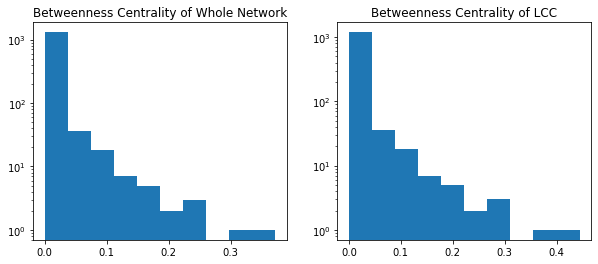

In [79]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.set_title('Betweenness Centrality of Whole Network')
ax2.set_title('Betweenness Centrality of LCC')
ax1.hist(betweenness_centrality.values(), bins=10, log=True)
ax2.hist(betweenness_centrality_lcc.values(), bins=10, log=True)
plt.show();

### *Closeness centrality:* inverse average path length. The closer a node are on average to every other nodes, the more central it is.

In [80]:
# For the Whole Network
closeness_centrality = bipartite.closeness_centrality(G, top_nodes)

# For the LCC
closeness_centrality_lcc = bipartite.closeness_centrality(G0, top_nodes_lcc)

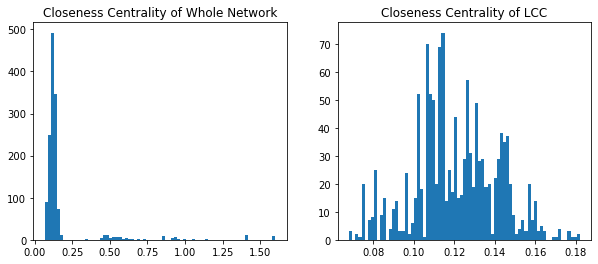

In [81]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.set_title('Closeness Centrality of Whole Network')
ax2.set_title('Closeness Centrality of LCC')
ax1.hist(closeness_centrality.values(), bins=75)
ax2.hist(closeness_centrality_lcc.values(), bins=75)
plt.show();

### *Avg degree:* average number of edges each node uses to connect to its neighbors. Depending on the number of nodes and the avg degree, we can have an idea of how connected or sparse our network is.

In [82]:
# Node Degree
node_degree = bipartite.degrees(G, top_nodes)
#print(node_degree[1]) # Maria: I don't understand the print structure
# node_degree[1] is showing the people nodes, and their corresponding degree
# node_degree[0] shows all the crime nodes, and their correponding degree

In [83]:
# People node with the most neighbors (Max left degree)
node_neighbors = {n: len(set(G.neighbors(n))) for n in top_nodes}
maxnode = max(node_neighbors, key = node_neighbors.get)
print(maxnode, node_neighbors[maxnode])

# People node in LCC with most neighbors
node_neighbors_lcc = {n: len(set(G0.neighbors(n))) for n in top_nodes_lcc}
maxnode_lcc = max(node_neighbors_lcc, key = node_neighbors_lcc.get)
print(maxnode_lcc, node_neighbors_lcc[maxnode_lcc])

p815 25
p815 25


In [84]:
# Crime node with the most neighbors (Max right degree)
node_neighbors = {n: len(set(G.neighbors(n))) for n in bottom_nodes}
maxnode = max(node_neighbors, key = node_neighbors.get)
print(maxnode, node_neighbors[maxnode])

node_neighbors_lcc = {n: len(set(G0.neighbors(n))) for n in bottom_nodes_lcc}
maxnode_lcc = max(node_neighbors_lcc, key = node_neighbors_lcc.get)
print(maxnode_lcc, node_neighbors_lcc[maxnode_lcc])

110 18
110 18


# Degree Distribution

## Some text explaining this...

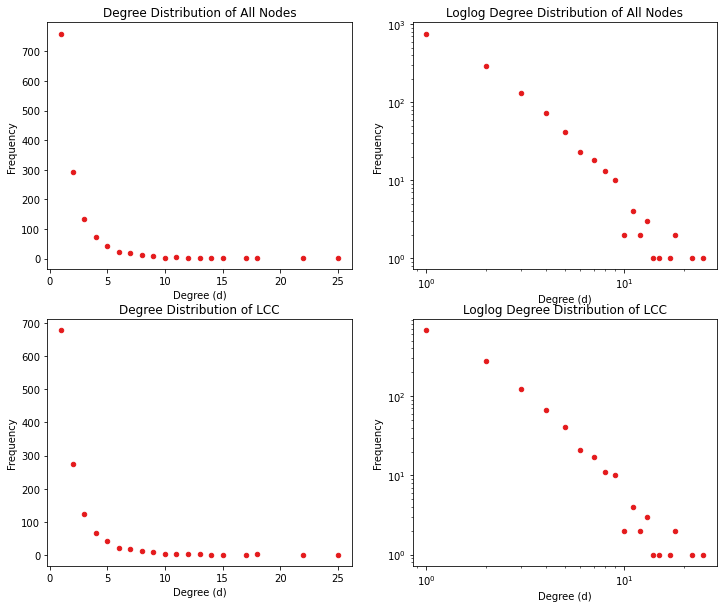

In [85]:
# Degree Distribution of the Entire Network, Combining People and Crime Nodes
dd = Counter(dict(G.degree).values())
dd = pd.DataFrame(list(dd.items()), columns = ("Degree (d)", "Frequency")).sort_values(by = "Degree (d)")

# Degree Distribution of the LCC, Combining People and Crime Nodes
dd_lcc = Counter(dict(G0.degree).values())
dd_lcc = pd.DataFrame(list(dd_lcc.items()), columns = ("Degree (d)", "Frequency")).sort_values(by = "Degree (d)")

fig, axs = plt.subplots(2,2, figsize=(12,10)) 
dd.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", ax=axs[0,0], color = "#e41a1c", title="Degree Distribution of All Nodes")
dd.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", ax=axs[0,1], color = "#e41a1c", loglog = True, title="Loglog Degree Distribution of All Nodes")

dd_lcc.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", ax=axs[1,0], color = "#e41a1c", title="Degree Distribution of LCC")
dd_lcc.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", ax=axs[1,1], color = "#e41a1c", loglog = True, title="Loglog Degree Distribution of LCC")
#plt.savefig("../Report/degree_distributions.png")
plt.show()

## People Vs Crime Node Degree Distribution

## Some text explaining this...

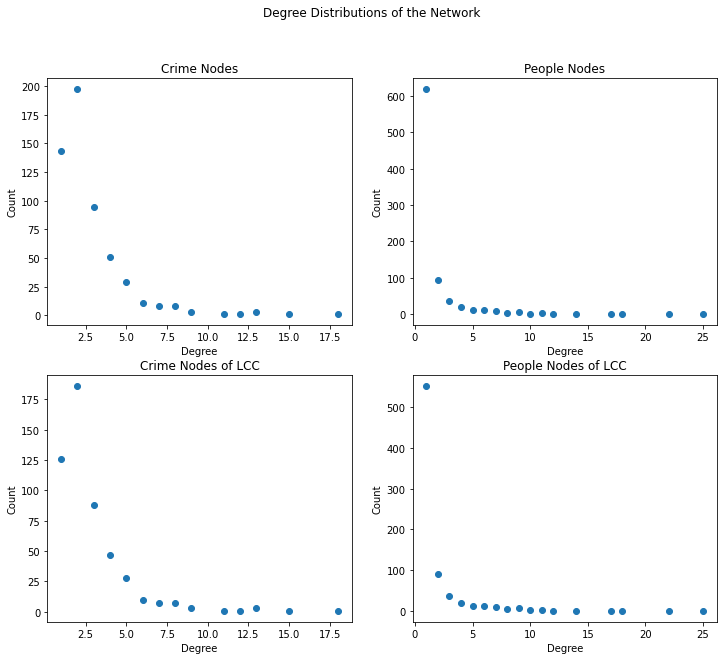

In [86]:
# This includes the entire graph
e_p = []
e_c = []
for k in G.nodes(): # Loop through all nodes
    if G.nodes[k]["bipartite"] == 0: # If People Nodes
        e_p.append(len(G.edges(k)))  # Append number of edges to each node
    else:                            # If Crime Nodes
        e_c.append(len(G.edges(k)))  # Append number of edges to each crime

e_cc = Counter(e_c)
e_pp = Counter(e_p)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,10))
fig.suptitle('Degree Distributions of the Network')

ax1.scatter(e_cc.keys(), e_cc.values())
ax1.set_title('Crime Nodes')
ax1.set_xlabel('Degree')
ax1.set_ylabel('Count')

ax2.scatter(e_pp.keys(), e_pp.values())
ax2.set_title('People Nodes')
ax2.set_xlabel('Degree')
ax2.set_ylabel('Count');

# This only deals with the LCC
# Lists of number of edges per node
e_p1 = [] # Number of edges connected to each People node
e_c1 = [] # Number of edges connected to each Crime node
for k in G0.nodes(): # loop through all nodes
    if G0.nodes[k]["bipartite"] == 0:  # If People Node
        e_p1.append(len(G0.edges(k)))  # Append number of edges to each node
    else:                              # If Crime Node
        e_c1.append(len(G0.edges(k)))  # Append number of edges to each node

e_cc1 = Counter(e_c1)
e_pp1 = Counter(e_p1)

#fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
#fig.suptitle('Degree Distributions of the Largest Connected Component')

ax3.scatter(e_cc1.keys(), e_cc1.values())
ax3.set_title('Crime Nodes of LCC')
ax3.set_xlabel('Degree')
ax3.set_ylabel('Count')

ax4.scatter(e_pp1.keys(), e_pp1.values())
ax4.set_title('People Nodes of LCC')
ax4.set_xlabel('Degree')
ax4.set_ylabel('Count');

# CCDF
## *Explanation*...

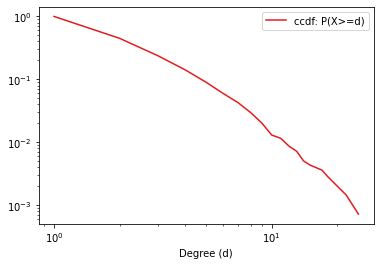

In [87]:
# Cumulative Degree distribution
ccdf = dd.sort_values(by = "Degree (d)", ascending = False)
ccdf["cumsum"] = ccdf["Frequency"].cumsum()
ccdf["ccdf: P(X>=d)"] = ccdf["cumsum"] / ccdf["Frequency"].sum()
ccdf = ccdf[["Degree (d)", "ccdf: P(X>=d)"]].sort_values(by = "Degree (d)")

ccdf.plot(kind = "line", x = "Degree (d)", y = "ccdf: P(X>=d)", color = "#e41a1c", loglog = True)
#plt.savefig("../Report/degree_distribution_ccdf.png")
plt.show()

## Fit CCDF to PowerLaw
## *Explanation*...

In [88]:
logcdf = np.log10(ccdf[["Degree (d)", "ccdf: P(X>=d)"]])
slope, log10intercept, r_value, p_value, std_err = linregress(logcdf["Degree (d)"], logcdf["ccdf: P(X>=d)"])
print("CCDF Fit: %1.4f x ^ %1.4f (R2 = %1.4f, p = %1.4f)" % (10 ** log10intercept, slope, r_value ** 2, p_value))
print("\n")

results = pl.Fit(ccdf["ccdf: P(X>=d)"])
k_min = ccdf[ccdf["ccdf: P(X>=d)"] == results.power_law.xmin]["Degree (d)"]
print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, results.power_law.alpha, k_min))

CCDF Fit: 2.4953 x ^ -2.2984 (R2 = 0.9663, p = 0.0000)


Powerlaw CCDF Fit: 11.5112 x ^ -1.4393 (k_min = 18)


Calculating best minimal value for power law fit
C:\Users\Sabrina\anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


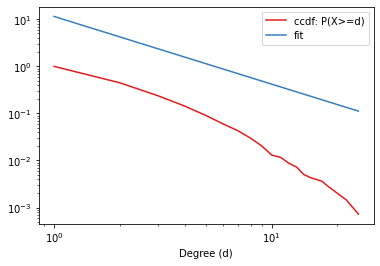

In [89]:
# Plot the best fit.
ccdf["fit"] = (10 ** results.power_law.Kappa) * (ccdf["Degree (d)"] ** -results.power_law.alpha)
ax = plt.gca()
ccdf.plot(kind = "line", x = "Degree (d)", y = "ccdf: P(X>=d)", color = "#e41a1c", loglog = True, ax = ax)
ccdf.plot(kind = "line", x = "Degree (d)", y = "fit", color = "#377eb8", loglog = True, ax = ax)
#plt.savefig("../Report/ccdf_fit.png")
plt.show()

## More Powerlaw Stuff
### *Explanation*...

In [90]:
# popt, pcov = curve_fit(log_f, ccdf["Degree (d)"], np.log10(ccdf["ccdf: P(X>=d)"]), p0 = (1, 1))
# ccdf["fit"] = ccdf.apply(lambda x: fu(x["Degree (d)"], popt[0], popt[1]), axis = 1)

# ax = plt.gca()
# ccdf.plot(kind = "line", x = "Degree (d)", y = "ccdf: P(X>=d)", color = "#e41a1c", loglog = True, ax = ax)
# ccdf.plot(kind = "line", x = "Degree (d)", y = "fit", color = "#377eb8", loglog = True, ax = ax)
# #plt.savefig("../Report/ccdf_fit.png")
# plt.show()

# Degree Distributions Per Node for Entire Network
## *Explanation*...

In [91]:
# This includes the entire network

# Dictionary of Crime Nodes and Their Degree
crimes_degree = list(G.degree(b))
crimes_degree = pd.DataFrame(crimes_degree, columns = ("Node", "Degree")).sort_values(by = "Node")

# Dictionary of Crime Node Degrees and Their Frequencies
crimes_degree_count = Counter(dict(G.degree(b)).values())
crimes_degree_count = pd.DataFrame(list(crimes_degree_count.items()), columns = ("Degree (d)", "Frequency")).sort_values(by = "Degree (d)")

In [92]:
# This includes the entire network

# Dictionary of People Nodes and Their Degree
ppl_degree = list(G.degree(a))
ppl_degree = pd.DataFrame(ppl_degree, columns = ("Node", "Degree")).sort_values(by = "Node")

# Dictionary of People Node Degrees and Their Frequencies
ppl_degree_count = Counter(dict(G.degree(a)).values())
ppl_degree_count = pd.DataFrame(list(ppl_degree_count.items()), columns = ("Degree (d)", "Frequency")).sort_values(by = "Degree (d)")
#ppl_degree_count

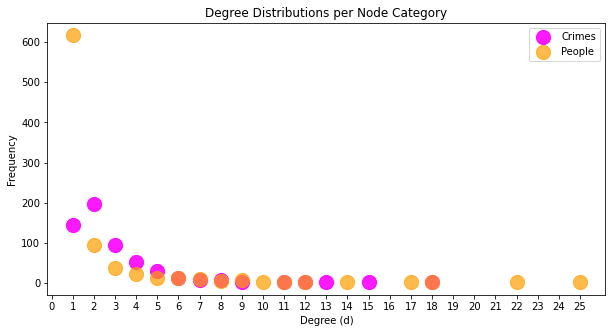

In [93]:
# This includes the entire network
fig, ax = plt.subplots(figsize=(10,5))
ax = plt.gca()
crimes_degree_count.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", color = "#fb00ff", ax = ax, alpha=0.9, s=200)
ppl_degree_count.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", color = "#ff9d00", ax = ax, alpha=0.7, s=200)
ax.legend(["Crimes","People"])
plt.xticks(np.arange(0, 26, step=1))
plt.title("Degree Distributions per Node Category")
plt.show()

# Degree Distribution Using only the LCC
## *Explanation*...

In [94]:
# Create DataFrame of People Nodes and their Degree
p_deg_lcc = list(G0.degree(a))
p_deg_lcc = pd.DataFrame(p_deg_lcc, columns = ("Node", "Degree")).sort_values(by = "Node")

# DataFrame of People Node Degrees and their Frequency
p_deg_lcc_count = Counter(dict(G0.degree(a)).values())
p_deg_lcc_count = pd.DataFrame(list(p_deg_lcc_count.items()), columns = ("Degree (d)", "Frequency")).sort_values(by = "Degree (d)")
#p_deg_lcc_count

In [95]:
# Create DataFrame of Crime Nodes and their Degree
c_deg_lcc = list(G0.degree(b))
c_deg_lcc = pd.DataFrame(c_deg_lcc, columns = ("Node", "Degree")).sort_values(by = "Node")

# Create DataFrame of Crime Node Degrees and their Frequency
c_deg_lcc_count = Counter(dict(G0.degree(b)).values())
c_deg_lcc_count = pd.DataFrame(list(c_deg_lcc_count.items()), columns = ("Degree (d)", "Frequency")).sort_values(by = "Degree (d)")
#crimes_degree_lcc_count

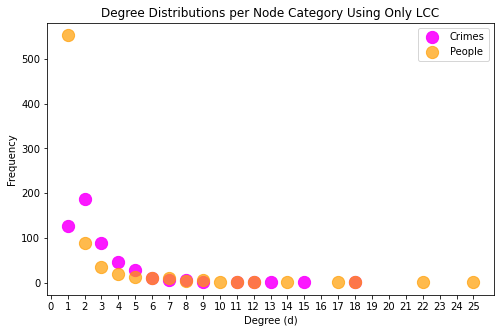

In [96]:
# This Uses Only the LCC
fig, ax = plt.subplots(figsize=(8,5))
ax = plt.gca()
c_deg_lcc_count.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", color = "#fb00ff", ax = ax, alpha=0.9, s=150)
p_deg_lcc_count.plot(kind = "scatter", x = "Degree (d)", y = "Frequency", color = "#ff9d00", ax = ax, alpha=0.7, s=150)

ax.legend(["Crimes","People"])
plt.xticks(np.arange(0, 26, step=1))
plt.title("Degree Distributions per Node Category Using Only LCC")
#plt.savefig("../Report/degree_distribution_lcc.png")
plt.show()

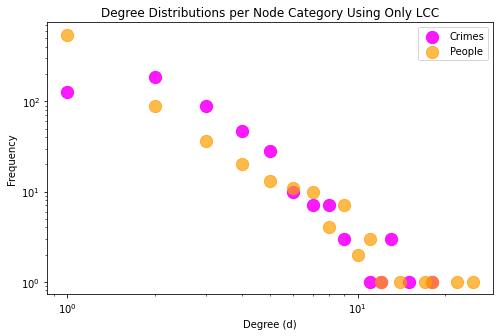

In [97]:
# This Uses Only the LCC
fig, ax = plt.subplots(figsize=(8,5)) 
ax = plt.gca()
c_deg_lcc_count.plot(kind = "scatter", loglog=True, x = "Degree (d)", y = "Frequency", color = "#fb00ff", ax = ax, alpha=0.9, s=150)
p_deg_lcc_count.plot(kind = "scatter", loglog=True, x = "Degree (d)", y = "Frequency", color = "#ff9d00", ax = ax, alpha=0.7, s=150)

ax.legend(["Crimes","People"])
plt.title("Degree Distributions per Node Category Using Only LCC")
#plt.savefig("../Report/degree_distribution_loglog_lcc.png")
plt.show()

In [98]:
# Degree distribution of Both Nodes in LCC
ccdf_lcc = dd_lcc.sort_values(by = "Degree (d)", ascending = False)
ccdf_lcc["cumsum"] = ccdf_lcc["Frequency"].cumsum()
ccdf_lcc["ccdf: P(X>=d)"] = ccdf_lcc["cumsum"] / ccdf_lcc["Frequency"].sum()
ccdf_lcc = ccdf_lcc[["Degree (d)", "ccdf: P(X>=d)"]].sort_values(by = "Degree (d)")

In [99]:
# Crime Degree Distribution Using Only LCC
c_ccdf = c_deg_lcc_count.sort_values(by = "Degree (d)", ascending = False)
c_ccdf["cumsum"] = c_ccdf["Frequency"].cumsum()
c_ccdf["ccdf: P(X>=d)"] = c_ccdf["cumsum"] / c_ccdf["Frequency"].sum()
c_ccdf = c_ccdf[["Degree (d)", "ccdf: P(X>=d)"]].sort_values(by = "Degree (d)")

In [100]:
# People Degree Distribution Using Only LCC
p_ccdf = p_deg_lcc_count.sort_values(by = "Degree (d)", ascending = False)
p_ccdf["cumsum"] = p_ccdf["Frequency"].cumsum()
p_ccdf["ccdf: P(X>=d)"] = p_ccdf["cumsum"] / p_ccdf["Frequency"].sum()
p_ccdf = p_ccdf[["Degree (d)", "ccdf: P(X>=d)"]].sort_values(by = "Degree (d)")

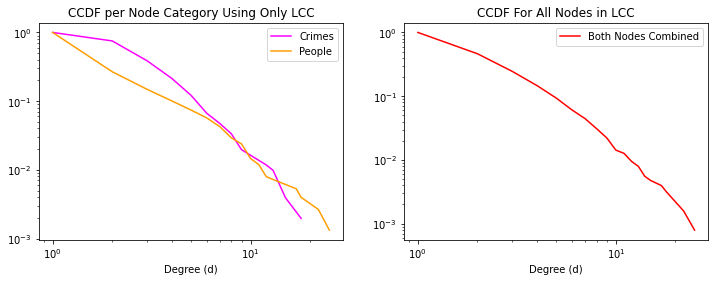

In [101]:
fig, axs = plt.subplots(1,2, figsize=(12,4)) 
ax = plt.gca()

c_ccdf.plot(kind = "line", x = "Degree (d)", y = "ccdf: P(X>=d)", ax=axs[0], color = "#fb00ff", loglog = True)
p_ccdf.plot(kind = "line", x = "Degree (d)", y = "ccdf: P(X>=d)", ax=axs[0], color = "#ff9d00", loglog = True)
axs[0].legend(["Crimes","People"])
axs[0].set_title("CCDF per Node Category Using Only LCC")

ccdf_lcc.plot(kind = "line", x = "Degree (d)", y = "ccdf: P(X>=d)", ax=axs[1], color = "r", loglog = True)
axs[1].legend(["Both Nodes Combined"])
axs[1].set_title("CCDF For All Nodes in LCC")


plt.show()

# Fit CCDF for LCC to PowerLaw
## *Explanation*...

In [102]:
logcdf_lcc = np.log10(ccdf_lcc[["Degree (d)", "ccdf: P(X>=d)"]])
slope, log10intercept, r_value, p_value, std_err = linregress(logcdf_lcc["Degree (d)"], logcdf_lcc["ccdf: P(X>=d)"])
print("CCDF Fit: %1.4f x ^ %1.4f (R2 = %1.4f, p = %1.4f)" % (10 ** log10intercept, slope, r_value ** 2, p_value))
print("\n")

results = pl.Fit(ccdf_lcc["ccdf: P(X>=d)"])
k_min = ccdf_lcc[ccdf_lcc["ccdf: P(X>=d)"] == results.power_law.xmin]["Degree (d)"]
print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, results.power_law.alpha, k_min))

CCDF Fit: 2.4807 x ^ -2.2655 (R2 = 0.9659, p = 0.0000)


Powerlaw CCDF Fit: 11.5334 x ^ -1.4448 (k_min = 18)


Calculating best minimal value for power law fit
C:\Users\Sabrina\anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


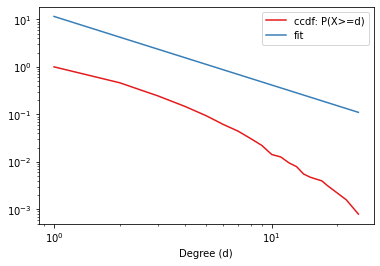

In [103]:
# Plot the best fit.
ccdf_lcc["fit"] = (10 ** results.power_law.Kappa) * (ccdf_lcc["Degree (d)"] ** -results.power_law.alpha)
ax = plt.gca()
ccdf_lcc.plot(kind = "line", x = "Degree (d)", y = "ccdf: P(X>=d)", color = "#e41a1c", loglog = True, ax = ax)
ccdf_lcc.plot(kind = "line", x = "Degree (d)", y = "fit", color = "#377eb8", loglog = True, ax = ax)
#plt.savefig("../Report/ccdf_lcc_fit.png")
plt.show()

# Projected Plots of the Entire Network

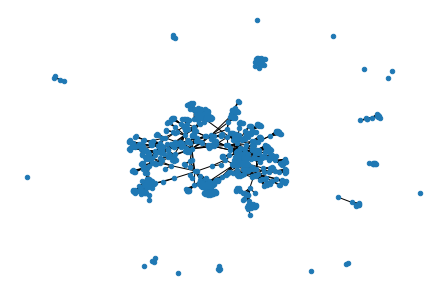

In [104]:
# The Entire Network of People
P = bipartite.weighted_projected_graph(G, top_nodes)
nx.draw(P, node_size=20)

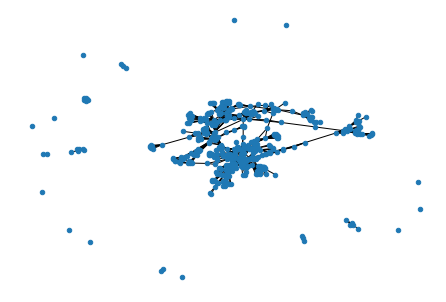

In [105]:
# The Entire Network of Crimes
C = bipartite.weighted_projected_graph(G, bottom_nodes)
nx.draw(C, node_size=20)

# Plots of Largest Connected Component

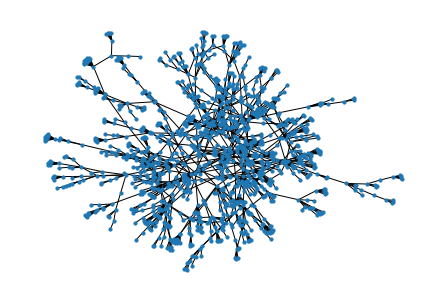

In [106]:
# plot only biggest component
pos = nx.spring_layout(G0)
posB = nx.bipartite_layout(G0, top_nodes)
biggest_comp_graph = nx.draw(G0,pos,node_size=10)

## Projected Graphs From Only the LCC

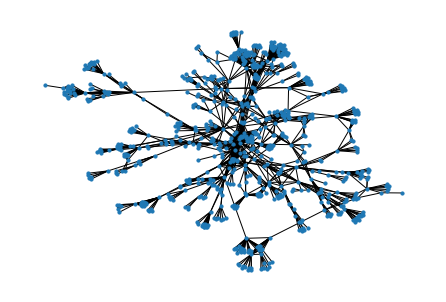

In [107]:
# Just the People from the LCC
P = bipartite.weighted_projected_graph(G0, top_nodes_lcc)
nx.draw(P, node_size=10)

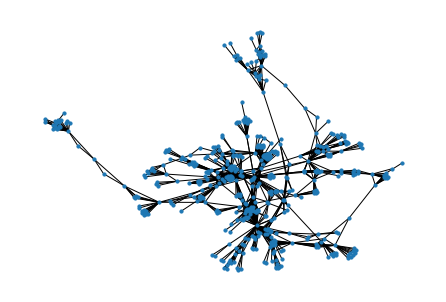

In [108]:
# Only Crimes from the LCC
C = bipartite.weighted_projected_graph(G0, bottom_nodes_lcc)
nx.draw(C, node_size=10)

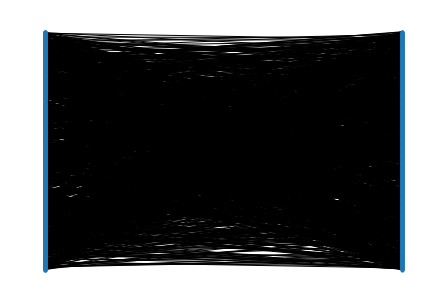

In [109]:
# Biggest component bipartite plot
biggest_comp_graph = nx.draw(G0,posB,node_size=10)

## Non-square adjacency matrix, and stocastic matrix

In [110]:
# Non-square adjacency matrix
adjmat = nx.algorithms.bipartite.matrix.biadjacency_matrix(G, top_nodes)
print(adjmat.shape)

(829, 551)


In [111]:
# Project along smaller axis
if adjmat.shape[0] == 551:
    adjmat_proj = adjmat.dot(adjmat.T)
else:
    adjmat_proj = adjmat.T.dot(adjmat)

In [112]:
# Make stocastic
adjmat_proj_stoc = adjmat_proj / adjmat_proj.sum(axis = 1)
print(adjmat_proj_stoc.shape)

(551, 551)


# Projections of suspect graph
 Projections of suspect graph  
 From the BCC extracted only the suspect edges and created a new graph that is not connected but still bipartite. From there projected onto people nodes.
- [ ] Figure out how to keep crime name as edge attribute

## Extract suspect edges
Created a new graph with only suspects to do further analysis (try projections).

In [113]:
# selected just the suspect edges
suspect_edges = [(p,c) for p,c,e in G0.edges(data=True) if e['role'] == 'Suspect']
#print(suspect_edges)

In [114]:
# getting all nodes that have suspect edges
sus_nodes = pd.DataFrame(suspect_edges, columns=['node', 'crime']).iloc[:,0].unique()
sus_nodes = set(sus_nodes)

## Suspect subgraph

In [115]:
GS = G0.edge_subgraph(suspect_edges)

In [116]:
print(
    'Num. of nodes: {} \nNum. of edges: {} \nIs bipartite? {} \nIs connected? {}'.format(
        GS.number_of_nodes(), 
        GS.number_of_edges(), 
        nx.is_bipartite(GS),
        nx.is_connected(GS)
        )
    )

Num. of nodes: 782 
Num. of edges: 641 
Is bipartite? True 
Is connected? False


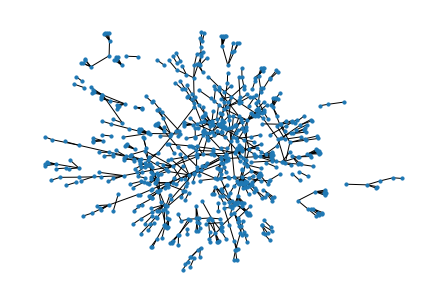

In [117]:
nx.draw(GS,pos,node_size=10)

## Projection on to suspect nodes (people)

In [118]:
nx.is_bipartite(GS)

True

In [119]:
# get the people and crime nodes
people_nodes_GS = {n for n, d in GS.nodes(data=True) if d["bipartite"] == 0}
crime_nodes_GS = set(GS) - people_nodes_GS

In [120]:
# projection of suspect graph
weighted_suspect_graph = nx.bipartite.weighted_projected_graph(GS, people_nodes_GS, ratio=False)
list(weighted_suspect_graph.edges(data=True))[0:5]

[('p199', 'p301', {'weight': 1}),
 ('p653', 'p829', {'weight': 1}),
 ('p653', 'p254', {'weight': 1}),
 ('p653', 'p219', {'weight': 1}),
 ('p653', 'p751', {'weight': 1})]

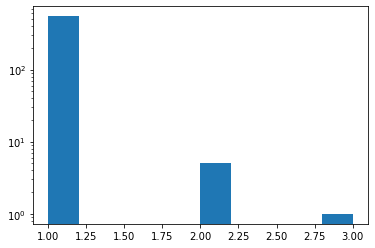

In [121]:
# give the number of shared neighbors
weights = list(nx.get_edge_attributes(weighted_suspect_graph, 'weight').values())

# plot weights
plt.hist(weights, bins = 10, log=True)
plt.show()

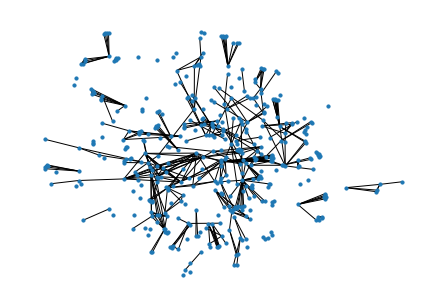

In [122]:
nx.draw(weighted_suspect_graph,pos,node_size=10)

In [124]:
print(
    'Num. of nodes: {} \nNum. of edges: {} \nIs bipartite? {} \nIs connected? {}'.format(
        weighted_suspect_graph.number_of_nodes(), 
        weighted_suspect_graph.number_of_edges(), 
        nx.is_bipartite(weighted_suspect_graph),
        nx.is_connected(weighted_suspect_graph)
        )
    )

Num. of nodes: 429 
Num. of edges: 553 
Is bipartite? False 
Is connected? False


In [123]:
nx.number_connected_components(weighted_suspect_graph)

150

In [125]:
# Components in the graph sorted in descendent order
sort_sus = sorted(nx.connected_components(weighted_suspect_graph), key=len, reverse=True)

# Selecting the biggest component
GS2 = weighted_suspect_graph.subgraph(sort_sus[0])

In [190]:
ew = nx.get_edge_attributes(GS2, 'weight')

In [191]:
options = {
    'node_color': 'orange',
    'node_size': 30,
    'edge_color': 'gray', 
    # 'linewidths': 1, 
    'width': list(ew.values()),
    'font_size': 8,
    'with_labels': False
}

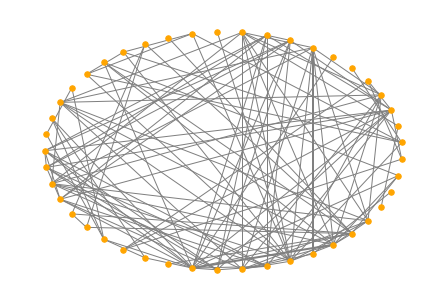

In [192]:
l = nx.shell_layout(GS2)
nx.draw(GS2, l, **options)

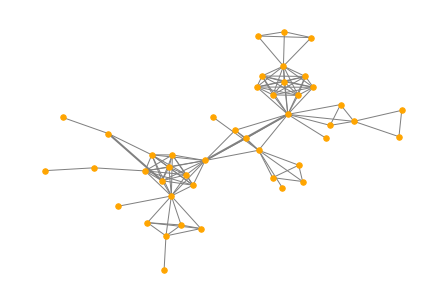

In [193]:
nx.draw_kamada_kawai(GS2, **options)